**In case of problems or questions, please first check the list of [Frequently Asked Questions (FAQ)](https://stardist.net/docs/faq.html).**

Please shutdown all other training/prediction notebooks before running this notebook (as those might occupy the GPU memory otherwise).

# NOTE

**If you have not looked at the [regular example notebooks](../2D), please do so first.**  
The notebooks in this folder provide further details about the inner workings of StarDist and might be useful if you want to apply it in a slightly different context.

In [13]:
from warnings import warn
from csbdeep.utils.tf import IS_TF_1, limit_gpu_memory
if not IS_TF_1:
    warn("This example will *very likely* only work with the older TensorFlow 1.x, but you have TensorFlow 2.x installed.")

There can be some issues with GPU memory while exporting the model. Either disable GPU acceleration or limit the GPU memory:

In [14]:
# # limit gpu memory
# limit_gpu_memory(0.75)

# disable gpu acceleration
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [15]:
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = None
import matplotlib.pyplot as plt
%matplotlib inline

from csbdeep.utils import normalize
from stardist import data, random_label_cmap, export_bioimageio, import_bioimageio
from stardist.models import StarDist2D
from pathlib import Path
cmap = random_label_cmap()

# Export StarDist model as bioimage.io model

Load the StarDist to be exported (can be your custom trained model; 3D is also supported):

In [16]:
model = StarDist2D.from_pretrained('2D_versatile_fluo')

Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


Load an example image suitable for this model, which will be used as a reference test image:

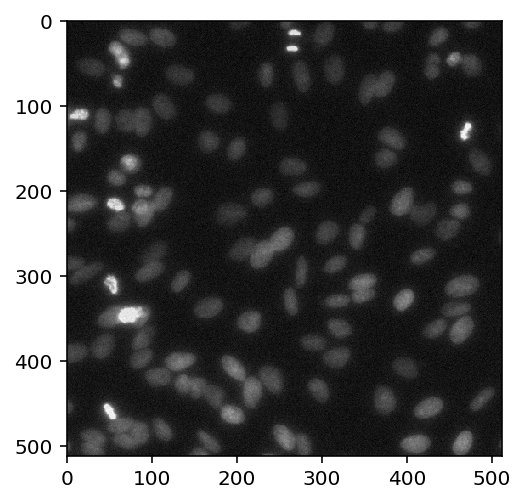

In [17]:
img = data.test_image_nuclei_2d()
plt.imshow(img, cmap='gray');

Choose a directory for the exported model:

In [18]:
outdir = Path("exported_bioimageio_model")
%rm -rf $outdir
%mkdir $outdir

The `export_bioimageio` function can then be used to export the StarDist model, which has the following options:  

**Note**: Image normalization is included as a pre-processing step of the exported model (percentile parameters). Hence, input images do not need to be normalized beforehand if this model is used for prediction elsewhere.

In [19]:
help(export_bioimageio)

Help on function export_bioimageio in module stardist.bioimageio_utils:

export_bioimageio(model, outpath, test_input, test_input_axes=None, test_input_norm_axes='ZYX', name='bioimageio_model', mode='tensorflow_saved_model_bundle', min_percentile=1.0, max_percentile=99.8, overwrite_spec_kwargs={})
    Export stardist model into bioimage.io format, https://github.com/bioimage-io/spec-bioimage-io.
    
    Parameters
    ----------
    model: StarDist2D, StarDist3D
        the model to convert
    outpath: str, Path
        where to save the model
    test_input: np.ndarray
        input image for generating test data
    test_input_axes: str or None
         the axes of the test input, for example 'YX' for a 2d image or 'ZYX' for a 3d volume
         using None assumes that axes of test_input are the same as those of model
    test_input_norm_axes: str
         the axes of the test input which will be jointly normalized, for example 'ZYX' for all spatial dimensions ('Z' ignored for 2D i

Export the model, including the test image:

In [20]:
export_bioimageio(model, outdir, img)

INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: /tmp/tmphjg9eihs/model/saved_model.pb


These are the created files (the important one is `bioimageio_model.zip`):

In [21]:
%ll -h $outdir

total 106M
-rw-rw-r-- 1 uwe  52M Feb  5 21:22 bioimageio_model.zip
-rw-rw-r-- 1 uwe  166 Feb  5 21:22 README.md
-rw-rw-r-- 1 uwe   44 Feb  5 21:22 requirements.txt
-rw-rw-r-- 1 uwe 1.8K Feb  5 21:22 stardist_postprocessing.ijm
-rw-rw-r-- 1 uwe 5.6M Feb  5 21:22 stardist_weights.h5
-rw-rw-r-- 1 uwe 1.1M Feb  5 21:22 test_input.npy
-rw-rw-r-- 1 uwe  34M Feb  5 21:22 test_output.npy
drwxrwxr-x 3 uwe 4.0K Feb  5 21:22 tf_model/
-rw-rw-r-- 1 uwe  16M Feb  5 21:22 TF_SavedModel.zip


# Import bioimage.io model as StarDist model

We now load the bioimage.io model from the zip file that we've just created, and then convert it back to a regular StarDist model.

The `import_bioimageio` function imports the bioimage.io model from `source` (e.g. a file path or url) and saves it to folder `dest`.

In [22]:
source = outdir / 'bioimageio_model.zip'
dest = Path("imported_model")
%rm -rf $dest

In [23]:
model_imported = import_bioimageio(source, dest)
model_imported

Loading network weights from 'stardist_weights.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


StarDist2D(imported_model): YXC → YXC
├─ Directory: /home/uwe/research/stardist/stardist-feature-branch/examples/other2D/imported_model
└─ Config2D(axes='YXC', backbone='unet', grid=(2, 2), n_channel_in=1, n_channel_out=33, n_classes=None, n_dim=2, n_rays=32, net_conv_after_unet=128, net_input_shape=[None, None, 1], net_mask_shape=[None, None, 1], train_background_reg=0.0001, train_batch_size=8, train_checkpoint='weights_best.h5', train_checkpoint_epoch='weights_now.h5', train_checkpoint_last='weights_last.h5', train_class_weights=[1, 1], train_completion_crop=32, train_dist_loss='mae', train_epochs=800, train_foreground_only=0.9, train_learning_rate=0.0003, train_loss_weights=[1, 0.2], train_n_val_patches=None, train_patch_size=[256, 256], train_reduce_lr={'factor': 0.5, 'min_delta': 0, 'patience': 80}, train_sample_cache=True, train_shape_completion=False, train_steps_per_epoch=400, train_tensorboard=True, unet_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_kernel_s

The imported model can be used like any other StarDist model, e.g. for prediction:

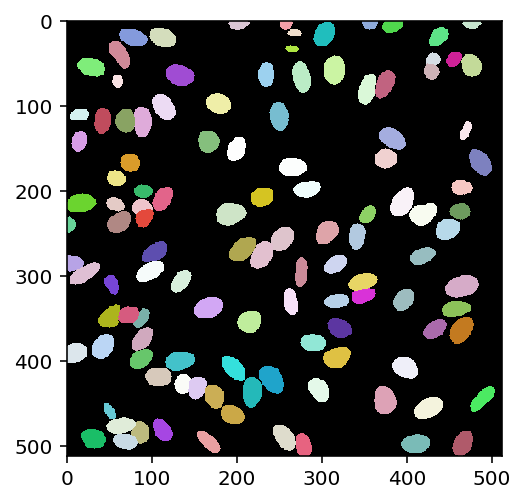

In [24]:
labels, polys = model_imported.predict_instances(normalize(img, 1.0, 99.8))
plt.imshow(labels, cmap=cmap);